## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [1]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'

In [3]:
data_df = pd.read_csv(data_location + file)

In [4]:
data_df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [5]:
data_df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [6]:
m = NeuralProphet()

In [7]:
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

In [8]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [9]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-10-08 01:00:00
Validation set time range:   2015-10-08 02:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


**Plot train_df**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
x_size = 16
y_size = 6
figsize = (x_size, y_size)

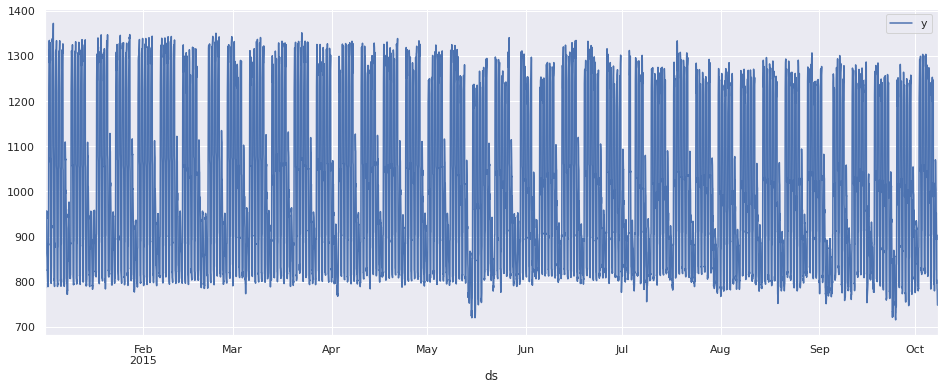

In [12]:
train_df.set_index('ds').plot(figsize=figsize);

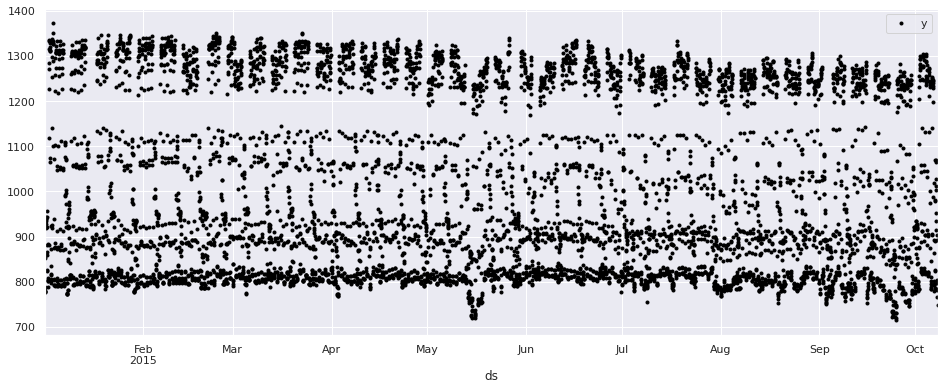

In [13]:
train_df.set_index('ds').plot(marker='.', linestyle='none', colormap='gray', figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: NP with default features
- `m2`: NP with parametric time-based features (like in Facebook Prophet)
- `m3`: NP with 1-layer AR
- `m4`: NP with 4-layer deep AR

In [14]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]

In [15]:
m1 = NeuralProphet(
    quantiles=quantiles,
)
m2 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m4 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. I recommend trying both ways to see how to performance evaluation metrics change.

In [16]:
%%time
random_seed = 0

# Conconate train_df and val_df as full training set
# set_random_seed(random_seed)
# metrics1 = m1.fit(pd.concat([train_df, val_df]), freq='H')
# set_random_seed(random_seed)
# metrics2 = m2.fit(pd.concat([train_df, val_df]), freq='H')
# set_random_seed(random_seed)
# metrics3 = m3.fit(pd.concat([train_df, val_df]), freq='H')
# set_random_seed(random_seed)
# metrics4 = m4.fit(pd.concat([train_df, val_df]), freq='H')

# Use val_df for validation
set_random_seed(random_seed)
metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics4 = m4.fit(train_df, freq='H', validation_df=val_df)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 114


  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 7.50E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 4.87E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.81E-02
  0%|          | 0/114 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([746])) that is different to the input size (torch.Size([746, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

Epoch[114/114]: 100%|██████████| 114/114 [00:54<00:00,  2.08it/s, SmoothL1Loss=0.00931, MAE=65, RMSE=80.6, Loss=0.00879, RegLoss=0, MAE_val=217, RMSE_val=266, SmoothL1Loss_val=0.0991]  
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal t

CPU times: user 7min 1s, sys: 486 ms, total: 7min 2s
Wall time: 3min 37s


In [17]:
metrics1.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.009311,64.955042,80.579487,0.008786,0.0,0.099053,216.876556,265.703339


In [18]:
metrics2.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.005676,44.631943,61.431704,0.01012,0.004564,0.107314,223.560593,276.480316


In [19]:
metrics3.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.001826,23.78648,35.067682,0.003231,0.001203,0.10699,218.762833,276.046082


In [20]:
metrics4.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.000155,7.240371,10.177473,0.000155,0.0,0.108465,219.429321,277.942871


**Get forecasts of out-of-sample (OOS) test_df**

In [21]:
forecast1 = m1.predict(test_df)
forecast2 = m2.predict(test_df)
forecast3 = m3.predict(test_df)
forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [22]:
forecast1.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
542,2015-12-31 20:00:00,845.563081,-65.527131,780.035950,706.236328,851.550842,984.190735,-101.501366,-102.653404
543,2015-12-31 21:00:00,827.530521,-83.501590,744.028931,661.513428,811.236877,984.187744,-93.026802,-147.132034
544,2015-12-31 22:00:00,829.256300,-111.620435,717.635864,626.382446,809.956055,984.184692,-84.362717,-182.186172
545,2015-12-31 23:00:00,813.937205,-107.142955,706.794250,619.462280,806.434509,984.181763,-75.566254,-201.821198
546,2016-01-01 00:00:00,815.588584,-104.146140,711.442444,628.700623,800.939636,984.178711,-66.694534,-206.041748


In [23]:
forecast2.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
542,2015-12-31 20:00:00,845.563081,-203.049775,642.513306,491.548157,689.260254,900.687744,-161.652573,-96.521873
543,2015-12-31 21:00:00,827.530521,-216.565189,610.965332,472.376221,671.093506,900.653076,-133.658920,-156.028824
544,2015-12-31 22:00:00,829.256300,-217.894056,611.362244,461.588745,651.608521,900.618347,-104.345787,-184.910339
545,2015-12-31 23:00:00,813.937205,-188.365550,625.571655,473.997742,674.857544,900.583740,-74.646706,-200.365326
546,2016-01-01 00:00:00,815.588584,-165.570944,650.017639,499.877106,674.434082,900.549072,-45.488739,-205.042679


In [24]:
forecast3.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
542,2015-12-31 20:00:00,845.563081,6.577911,852.140991,811.594238,895.508667,103.758713,748.382263
543,2015-12-31 21:00:00,827.530521,-53.622318,773.908203,733.36322,817.275635,25.525883,748.382263
544,2015-12-31 22:00:00,829.256300,-5.542066,823.714233,783.170898,867.081665,75.33197,748.382263
545,2015-12-31 23:00:00,813.937205,24.424733,838.361938,797.819031,881.729492,89.97963,748.382263
546,2016-01-01 00:00:00,815.588584,18.133645,833.722229,793.179749,877.090088,85.339928,748.382263


In [25]:
forecast4.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
542,2015-12-31 20:00:00,845.563081,2.199859,847.762939,838.656372,855.743652,-103.348923,951.111877
543,2015-12-31 21:00:00,827.530521,-8.931888,818.598633,813.212341,825.671204,-132.51326,951.111877
544,2015-12-31 22:00:00,829.256300,-9.547804,819.708496,809.554565,827.430908,-131.403366,951.111877
545,2015-12-31 23:00:00,813.937205,1.082265,815.01947,804.521851,823.133667,-136.092438,951.111877
546,2016-01-01 00:00:00,815.588584,-3.049887,812.538696,803.751587,817.918579,-138.573196,951.111877


**Plot QR forecasts with OOS test_df**

In [26]:
cutoff = 7*24 # 0
x_size = 10
y_size = 5
figsize = (x_size, y_size)
plotting_backend = 'default'

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


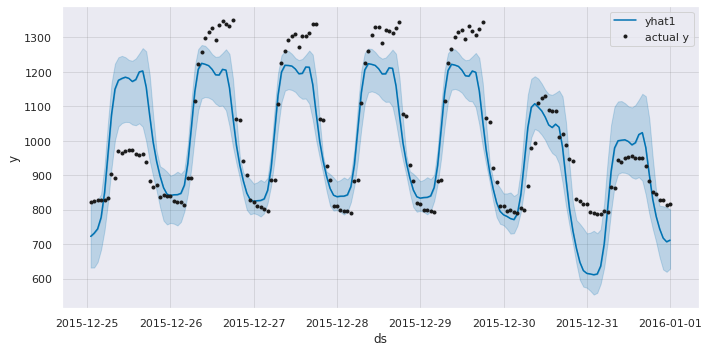

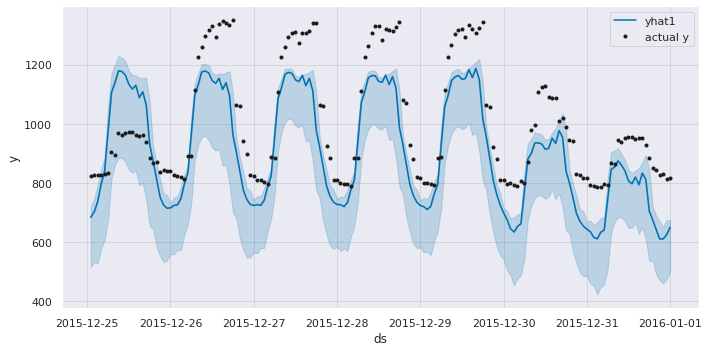

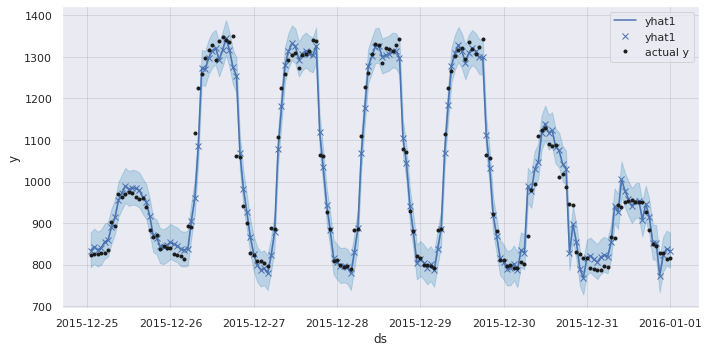

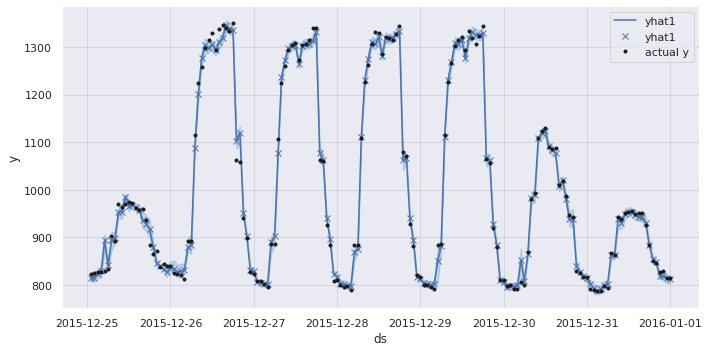

In [27]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

### Conformalize and plot

In [28]:
alpha = 0.1

**Naive**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


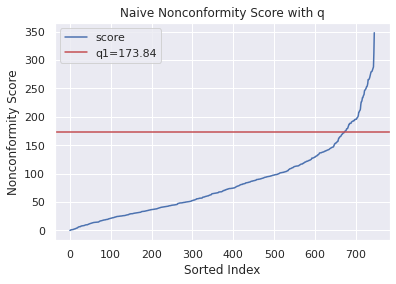

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


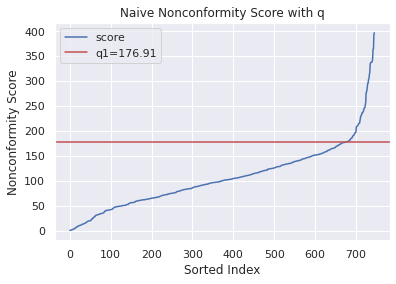

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


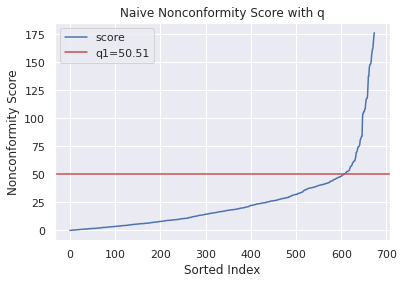

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


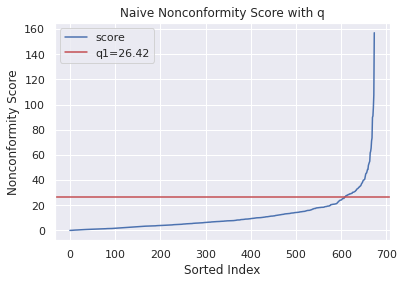

In [29]:
method='naive'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [30]:
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4

(173.84114604062495,
 176.90842283828124,
 50.513631634374974,
 26.418522632812483)

Get forecasts and *naive* conformal prediction interval of OOS test_df

In [31]:
naive_forecast1 = m1.predict(test_df)
naive_forecast2 = m2.predict(test_df)
naive_forecast3 = m3.predict(test_df)
naive_forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [32]:
# method='naive'
# naive_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [33]:
naive_forecast1.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
542,2015-12-31 20:00:00,845.563081,-65.527131,780.035950,706.236328,851.550842,984.190735,-101.501366,-102.653404,606.194804,953.877096
543,2015-12-31 21:00:00,827.530521,-83.501590,744.028931,661.513428,811.236877,984.187744,-93.026802,-147.132034,570.187785,917.870077
544,2015-12-31 22:00:00,829.256300,-111.620435,717.635864,626.382446,809.956055,984.184692,-84.362717,-182.186172,543.794718,891.477010
545,2015-12-31 23:00:00,813.937205,-107.142955,706.794250,619.462280,806.434509,984.181763,-75.566254,-201.821198,532.953104,880.635397
546,2016-01-01 00:00:00,815.588584,-104.146140,711.442444,628.700623,800.939636,984.178711,-66.694534,-206.041748,537.601298,885.283590


In [34]:
naive_forecast2.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
542,2015-12-31 20:00:00,845.563081,-203.049775,642.513306,491.548157,689.260254,900.687744,-161.652573,-96.521873,465.604883,819.421729
543,2015-12-31 21:00:00,827.530521,-216.565189,610.965332,472.376221,671.093506,900.653076,-133.658920,-156.028824,434.056909,787.873755
544,2015-12-31 22:00:00,829.256300,-217.894056,611.362244,461.588745,651.608521,900.618347,-104.345787,-184.910339,434.453821,788.270666
545,2015-12-31 23:00:00,813.937205,-188.365550,625.571655,473.997742,674.857544,900.583740,-74.646706,-200.365326,448.663232,802.480078
546,2016-01-01 00:00:00,815.588584,-165.570944,650.017639,499.877106,674.434082,900.549072,-45.488739,-205.042679,473.109216,826.926062


In [35]:
naive_forecast3.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
542,2015-12-31 20:00:00,845.563081,6.577911,852.140991,811.594238,895.508667,103.758713,748.382263,801.62736,902.654623
543,2015-12-31 21:00:00,827.530521,-53.622318,773.908203,733.36322,817.275635,25.525883,748.382263,723.394571,824.421835
544,2015-12-31 22:00:00,829.256300,-5.542066,823.714233,783.170898,867.081665,75.33197,748.382263,773.200602,874.227865
545,2015-12-31 23:00:00,813.937205,24.424733,838.361938,797.819031,881.729492,89.97963,748.382263,787.848307,888.87557
546,2016-01-01 00:00:00,815.588584,18.133645,833.722229,793.179749,877.090088,85.339928,748.382263,783.208597,884.235861


In [36]:
naive_forecast4.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
542,2015-12-31 20:00:00,845.563081,2.199859,847.762939,838.656372,855.743652,-103.348923,951.111877,821.344417,874.181462
543,2015-12-31 21:00:00,827.530521,-8.931888,818.598633,813.212341,825.671204,-132.51326,951.111877,792.18011,845.017155
544,2015-12-31 22:00:00,829.256300,-9.547804,819.708496,809.554565,827.430908,-131.403366,951.111877,793.289973,846.127019
545,2015-12-31 23:00:00,813.937205,1.082265,815.01947,804.521851,823.133667,-136.092438,951.111877,788.600948,841.437993
546,2016-01-01 00:00:00,815.588584,-3.049887,812.538696,803.751587,817.918579,-138.573196,951.111877,786.120174,838.957219


Plot QR forecasts and *naive* conformal prediction intervals with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


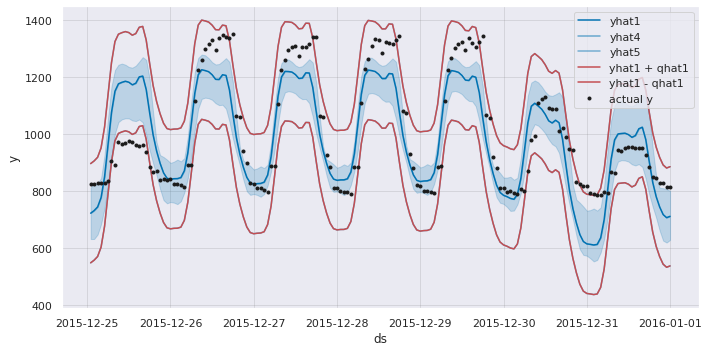

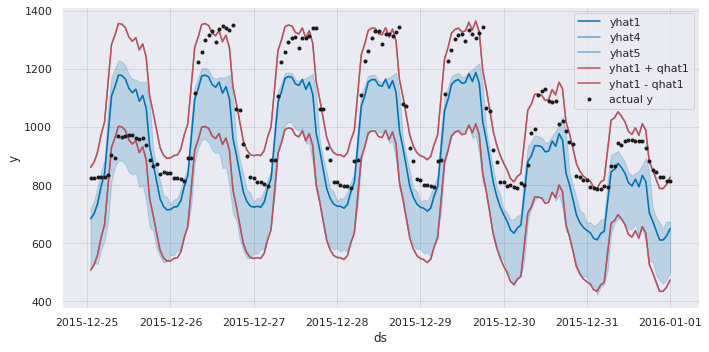

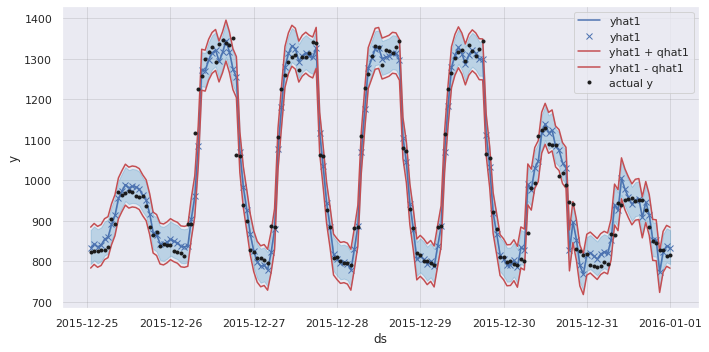

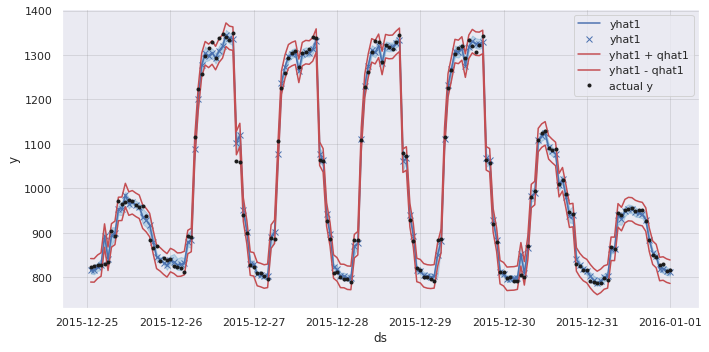

In [37]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


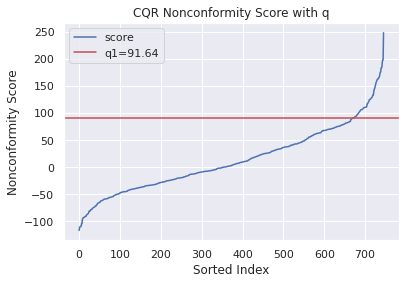

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


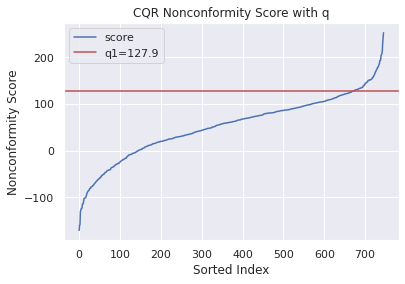

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


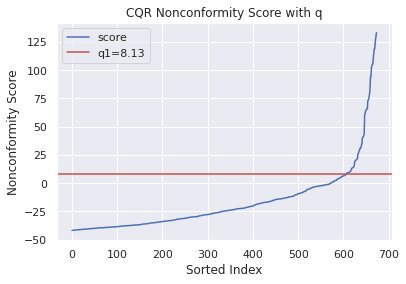

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


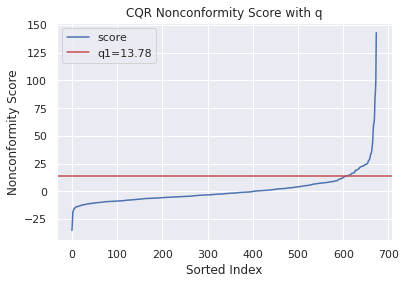

In [38]:
method='cqr'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [39]:
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(91.64095524765628, 127.89549846953128, 8.132101773437398, 13.77526935703122)

Get forecasts and *CQR* conformal prediction interval of OOS test_df

In [40]:
cqr_forecast1 = m1.predict(test_df)
cqr_forecast2 = m2.predict(test_df)
cqr_forecast3 = m3.predict(test_df)
cqr_forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [41]:
# method='cqr'
# cqr_adv_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [42]:
cqr_forecast1.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,-65.527131,780.035950,706.236328,851.550842,984.190735,-101.501366,-102.653404,759.909887,943.191798,614.595373,797.877283
543,2015-12-31 21:00:00,827.530521,-83.501590,744.028931,661.513428,811.236877,984.187744,-93.026802,-147.132034,719.595922,902.877833,569.872472,753.154383
544,2015-12-31 22:00:00,829.256300,-111.620435,717.635864,626.382446,809.956055,984.184692,-84.362717,-182.186172,718.315099,901.597010,534.741491,718.023402
545,2015-12-31 23:00:00,813.937205,-107.142955,706.794250,619.462280,806.434509,984.181763,-75.566254,-201.821198,714.793554,898.075465,527.821325,711.103236
546,2016-01-01 00:00:00,815.588584,-104.146140,711.442444,628.700623,800.939636,984.178711,-66.694534,-206.041748,709.298681,892.580591,537.059667,720.341578


In [43]:
cqr_forecast2.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,-203.049775,642.513306,491.548157,689.260254,900.687744,-161.652573,-96.521873,561.364755,817.155752,363.652658,619.443655
543,2015-12-31 21:00:00,827.530521,-216.565189,610.965332,472.376221,671.093506,900.653076,-133.658920,-156.028824,543.198007,798.989004,344.480722,600.271719
544,2015-12-31 22:00:00,829.256300,-217.894056,611.362244,461.588745,651.608521,900.618347,-104.345787,-184.910339,523.713022,779.504019,333.693247,589.484244
545,2015-12-31 23:00:00,813.937205,-188.365550,625.571655,473.997742,674.857544,900.583740,-74.646706,-200.365326,546.962045,802.753042,346.102243,601.893240
546,2016-01-01 00:00:00,815.588584,-165.570944,650.017639,499.877106,674.434082,900.549072,-45.488739,-205.042679,546.538584,802.329581,371.981607,627.772604


In [44]:
cqr_forecast3.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,6.577911,852.140991,811.594238,895.508667,103.758713,748.382263,887.376565,903.640769,803.462137,819.72634
543,2015-12-31 21:00:00,827.530521,-53.622318,773.908203,733.36322,817.275635,25.525883,748.382263,809.143533,825.407737,725.231118,741.495322
544,2015-12-31 22:00:00,829.256300,-5.542066,823.714233,783.170898,867.081665,75.33197,748.382263,858.949563,875.213767,775.038797,791.303
545,2015-12-31 23:00:00,813.937205,24.424733,838.361938,797.819031,881.729492,89.97963,748.382263,873.59739,889.861594,789.686929,805.951133
546,2016-01-01 00:00:00,815.588584,18.133645,833.722229,793.179749,877.090088,85.339928,748.382263,868.957986,885.22219,785.047647,801.31185


In [45]:
cqr_forecast4.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,2.199859,847.762939,838.656372,855.743652,-103.348923,951.111877,841.968383,869.518922,824.881103,852.431641
543,2015-12-31 21:00:00,827.530521,-8.931888,818.598633,813.212341,825.671204,-132.51326,951.111877,811.895934,839.446473,799.437072,826.987611
544,2015-12-31 22:00:00,829.256300,-9.547804,819.708496,809.554565,827.430908,-131.403366,951.111877,813.655639,841.206178,795.779296,823.329835
545,2015-12-31 23:00:00,813.937205,1.082265,815.01947,804.521851,823.133667,-136.092438,951.111877,809.358398,836.908936,790.746581,818.29712
546,2016-01-01 00:00:00,815.588584,-3.049887,812.538696,803.751587,817.918579,-138.573196,951.111877,804.14331,831.693848,789.976318,817.526856


Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


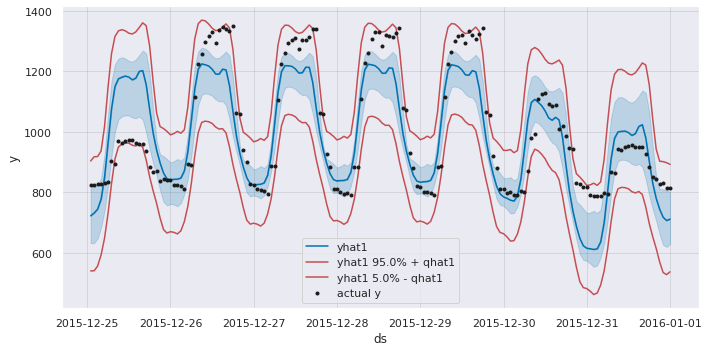

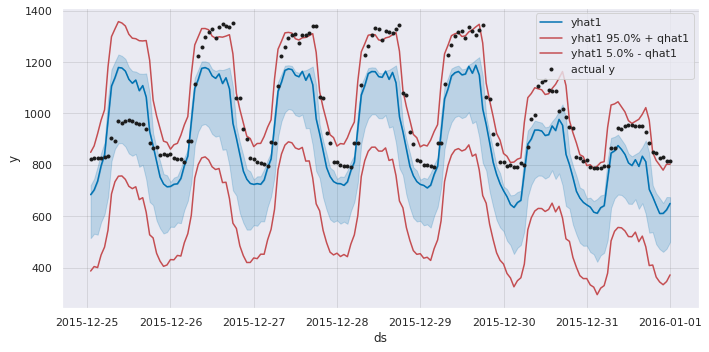

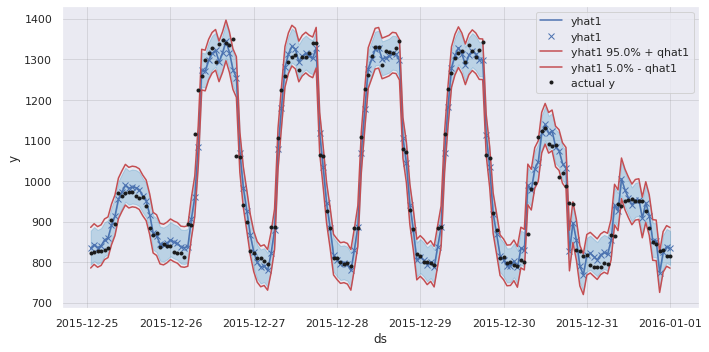

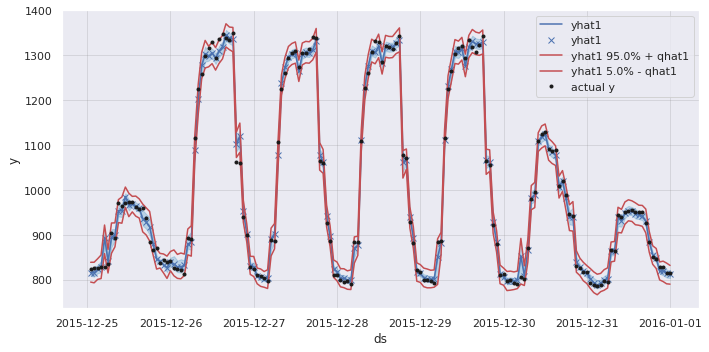

In [46]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR Advanced**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


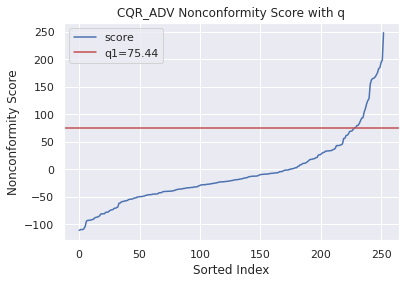

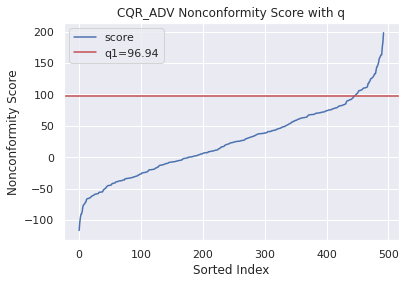

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


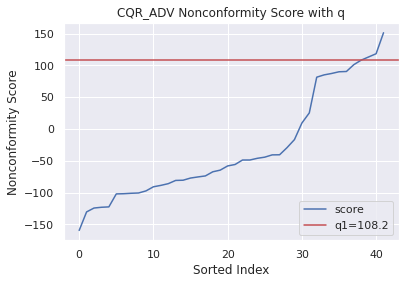

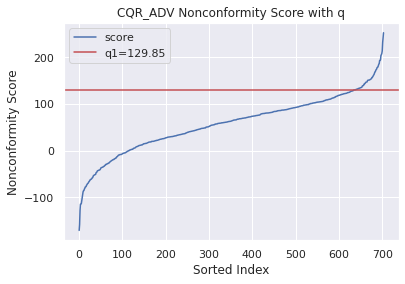

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


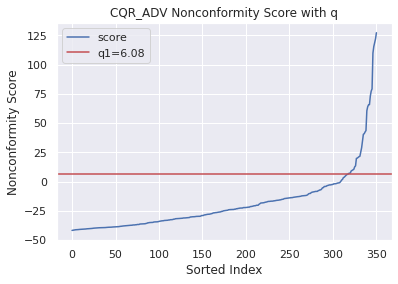

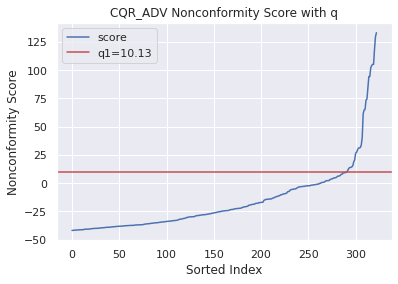

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


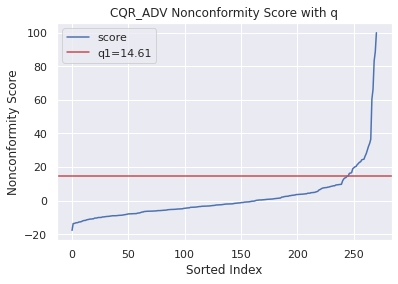

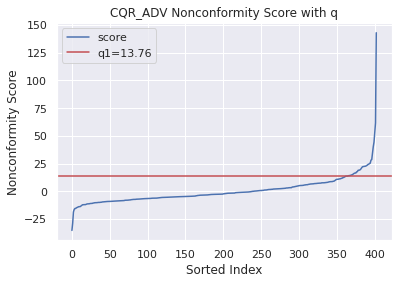

In [47]:
method='cqr_adv'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [48]:
cqr_lo_qhat1, cqr_lo_qhat2, cqr_lo_qhat3, cqr_lo_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_hi_qhat1, cqr_hi_qhat2, cqr_hi_qhat3, cqr_hi_qhat4 = m1.q_hats[1], m2.q_hats[1], m3.q_hats[1], m4.q_hats[1]

cqr_lo_qhat1, cqr_hi_qhat1, cqr_lo_qhat2, cqr_hi_qhat2, cqr_lo_qhat3, cqr_hi_qhat3, cqr_lo_qhat4, cqr_hi_qhat4

(75.44243956484377,
 96.94403220312495,
 108.20045965625002,
 129.84953667187506,
 6.077447257812537,
 10.125692484374895,
 14.610477617187485,
 13.755699112499997)

In [49]:
# Compare again with CQR
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(91.64095524765628, 127.89549846953128, 8.132101773437398, 13.77526935703122)

Get forecasts and *CQR Advanced* conformal prediction interval of OOS test_df

In [50]:
cqr_adv_forecast1 = m1.predict(test_df)
cqr_adv_forecast2 = m2.predict(test_df)
cqr_adv_forecast3 = m3.predict(test_df)
cqr_adv_forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [51]:
cqr_adv_forecast1.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,-65.527131,780.035950,706.236328,851.550842,984.190735,-101.501366,-102.653404,754.606810,948.494874,630.793889,781.678768
543,2015-12-31 21:00:00,827.530521,-83.501590,744.028931,661.513428,811.236877,984.187744,-93.026802,-147.132034,714.292845,908.180910,586.070988,736.955867
544,2015-12-31 22:00:00,829.256300,-111.620435,717.635864,626.382446,809.956055,984.184692,-84.362717,-182.186172,713.012022,906.900087,550.940007,701.824886
545,2015-12-31 23:00:00,813.937205,-107.142955,706.794250,619.462280,806.434509,984.181763,-75.566254,-201.821198,709.490477,903.378541,544.019841,694.904720
546,2016-01-01 00:00:00,815.588584,-104.146140,711.442444,628.700623,800.939636,984.178711,-66.694534,-206.041748,703.995604,897.883668,553.258183,704.143062


In [52]:
cqr_adv_forecast2.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,-203.049775,642.513306,491.548157,689.260254,900.687744,-161.652573,-96.521873,559.410717,819.109791,383.347697,599.748616
543,2015-12-31 21:00:00,827.530521,-216.565189,610.965332,472.376221,671.093506,900.653076,-133.658920,-156.028824,541.243969,800.943043,364.175761,580.576680
544,2015-12-31 22:00:00,829.256300,-217.894056,611.362244,461.588745,651.608521,900.618347,-104.345787,-184.910339,521.758984,781.458057,353.388285,569.789205
545,2015-12-31 23:00:00,813.937205,-188.365550,625.571655,473.997742,674.857544,900.583740,-74.646706,-200.365326,545.008007,804.707081,365.797282,582.198201
546,2016-01-01 00:00:00,815.588584,-165.570944,650.017639,499.877106,674.434082,900.549072,-45.488739,-205.042679,544.584545,804.283619,391.676646,608.077565


In [53]:
cqr_adv_forecast3.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,6.577911,852.140991,811.594238,895.508667,103.758713,748.382263,885.382975,905.634359,805.516791,817.671686
543,2015-12-31 21:00:00,827.530521,-53.622318,773.908203,733.36322,817.275635,25.525883,748.382263,807.149942,827.401327,727.285773,739.440667
544,2015-12-31 22:00:00,829.256300,-5.542066,823.714233,783.170898,867.081665,75.33197,748.382263,856.955973,877.207358,777.093451,789.248346
545,2015-12-31 23:00:00,813.937205,24.424733,838.361938,797.819031,881.729492,89.97963,748.382263,871.6038,891.855185,791.741584,803.896478
546,2016-01-01 00:00:00,815.588584,18.133645,833.722229,793.179749,877.090088,85.339928,748.382263,866.964395,887.21578,787.102301,799.257196


In [54]:
cqr_adv_forecast4.tail()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
542,2015-12-31 20:00:00,845.563081,2.199859,847.762939,838.656372,855.743652,-103.348923,951.111877,841.987953,869.499351,824.045894,853.26685
543,2015-12-31 21:00:00,827.530521,-8.931888,818.598633,813.212341,825.671204,-132.51326,951.111877,811.915505,839.426903,798.601864,827.822819
544,2015-12-31 22:00:00,829.256300,-9.547804,819.708496,809.554565,827.430908,-131.403366,951.111877,813.675209,841.186607,794.944088,824.165043
545,2015-12-31 23:00:00,813.937205,1.082265,815.01947,804.521851,823.133667,-136.092438,951.111877,809.377968,836.889366,789.911373,819.132328
546,2016-01-01 00:00:00,815.588584,-3.049887,812.538696,803.751587,817.918579,-138.573196,951.111877,804.16288,831.674278,789.141109,818.362065


Plot QR forecasts and *CQR Advanced* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


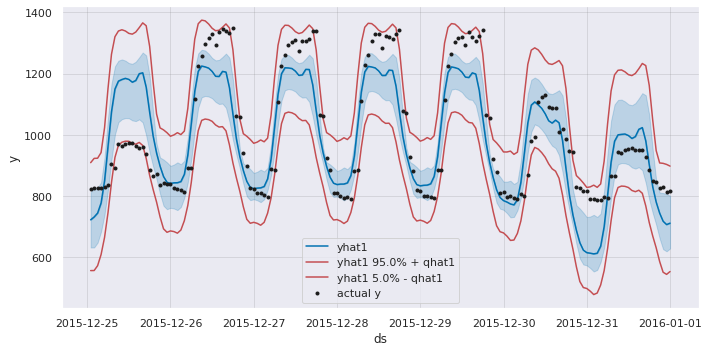

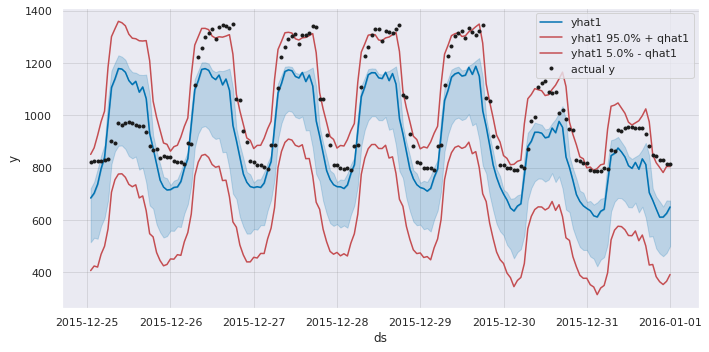

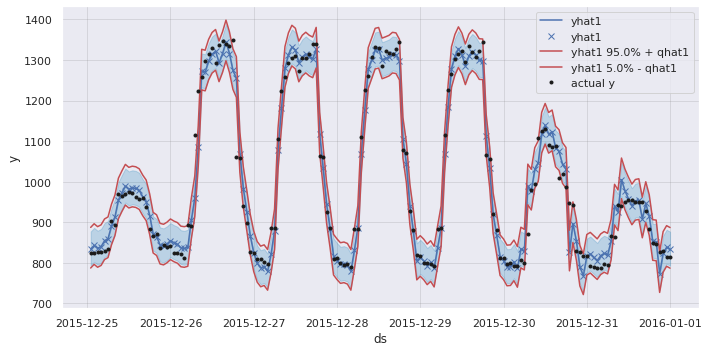

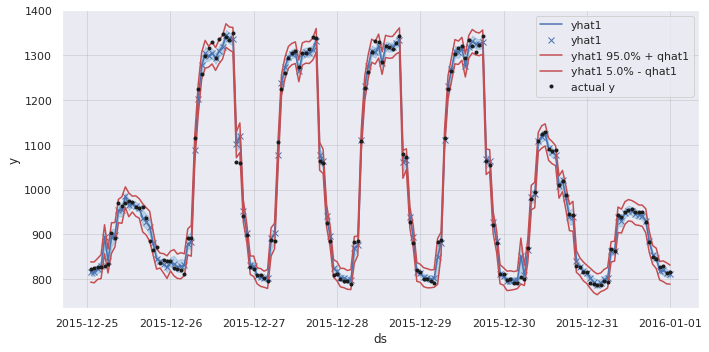

In [55]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [56]:
conformal_methods = ['naive', 'cqr', 'cqr_adv']
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ['interval_width','miscoverage_rate']]))
eval_df = eval_df.reset_index().rename(columns={'index': 'model'})

Enter in the model names

In [57]:
eval_df['model'] = ['m1', 'm2', 'm3', 'm4']

Enter in the **interval_width** (*efficiency* metric)

In [58]:
eval_df['naive', 'interval_width'] = [naive_qhat1*2, naive_qhat2*2, naive_qhat3*2, naive_qhat4*2]

qr_lo_mean1 = cqr_forecast1['yhat1'].mean() - cqr_forecast1['yhat1 5.0%'].mean()
qr_hi_mean1 = cqr_forecast1['yhat1 95.0%'].mean() - cqr_forecast1['yhat1'].mean()
qr_lo_mean2 = cqr_forecast2['yhat1'].mean() - cqr_forecast2['yhat1 5.0%'].mean()
qr_hi_mean2 = cqr_forecast2['yhat1 95.0%'].mean() - cqr_forecast2['yhat1'].mean()
qr_lo_mean3 = cqr_forecast3['yhat1'].mean() - cqr_forecast3['yhat1 5.0%'].mean()
qr_hi_mean3 = cqr_forecast3['yhat1 95.0%'].mean() - cqr_forecast3['yhat1'].mean()
qr_lo_mean4 = cqr_forecast4['yhat1'].mean() - cqr_forecast4['yhat1 5.0%'].mean()
qr_hi_mean4 = cqr_forecast4['yhat1 95.0%'].mean() - cqr_forecast4['yhat1'].mean()
eval_df['cqr', 'interval_width'] = [qr_lo_mean1 + qr_hi_mean1 + cqr_qhat1*2, \
                                    qr_lo_mean2 + qr_hi_mean2 + cqr_qhat2*2, \
                                    qr_lo_mean3 + qr_hi_mean3 + cqr_qhat3*2, \
                                    qr_lo_mean4 + qr_hi_mean4 + cqr_qhat4*2
                                    ]

qr_lo_mean1 = cqr_adv_forecast1['yhat1'].mean() - cqr_adv_forecast1['yhat1 5.0%'].mean()
qr_hi_mean1 = cqr_adv_forecast1['yhat1 95.0%'].mean() - cqr_adv_forecast1['yhat1'].mean()
qr_lo_mean2 = cqr_adv_forecast2['yhat1'].mean() - cqr_adv_forecast2['yhat1 5.0%'].mean()
qr_hi_mean2 = cqr_adv_forecast2['yhat1 95.0%'].mean() - cqr_adv_forecast2['yhat1'].mean()
qr_lo_mean3 = cqr_adv_forecast3['yhat1'].mean() - cqr_adv_forecast3['yhat1 5.0%'].mean()
qr_hi_mean3 = cqr_adv_forecast3['yhat1 95.0%'].mean() - cqr_adv_forecast3['yhat1'].mean()
qr_lo_mean4 = cqr_adv_forecast4['yhat1'].mean() - cqr_adv_forecast4['yhat1 5.0%'].mean()
qr_hi_mean4 = cqr_adv_forecast4['yhat1 95.0%'].mean() - cqr_adv_forecast4['yhat1'].mean()
eval_df['cqr_adv', 'interval_width'] = [qr_lo_mean1 + qr_hi_mean1 + cqr_lo_qhat1 + cqr_hi_qhat1, \
                                        qr_lo_mean2 + qr_hi_mean2 + cqr_lo_qhat2 + cqr_hi_qhat2, \
                                        qr_lo_mean3 + qr_hi_mean3 + cqr_lo_qhat3 + cqr_hi_qhat3, \
                                        qr_lo_mean4 + qr_hi_mean4 + cqr_lo_qhat4 + cqr_hi_qhat4
                                        ]

Enter in the **miscoverage rate** (*validity* metric)

In [59]:
naive_forecast1['check'] = naive_forecast1.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast2['check'] = naive_forecast2.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast3['check'] = naive_forecast3.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast4['check'] = naive_forecast4.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_coverage1 = naive_forecast1['check'].sum() / len(naive_forecast1)
naive_coverage2 = naive_forecast2['check'].sum() / len(naive_forecast2)
naive_coverage3 = naive_forecast3['check'].sum() / len(naive_forecast3)
naive_coverage4 = naive_forecast4['check'].sum() / len(naive_forecast4)
eval_df['naive', 'miscoverage_rate'] = [1-naive_coverage1, 1-naive_coverage2, 1-naive_coverage3, 1-naive_coverage4]  # 1 - coverage for the miscoverage

In [60]:
quantile_lo_str = str(quantile_lo*100)
quantile_hi_str = str(quantile_hi*100)
cqr_forecast1['check'] = cqr_forecast1.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_forecast2['check'] = cqr_forecast2.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_forecast3['check'] = cqr_forecast3.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_forecast4['check'] = cqr_forecast4.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_coverage1 = cqr_forecast1['check'].sum() / len(cqr_forecast1)
cqr_coverage2 = cqr_forecast2['check'].sum() / len(cqr_forecast2)
cqr_coverage3 = cqr_forecast3['check'].sum() / len(cqr_forecast3)
cqr_coverage4 = cqr_forecast4['check'].sum() / len(cqr_forecast4)
eval_df['cqr', 'miscoverage_rate'] = [1-cqr_coverage1, 1-cqr_coverage2, 1-cqr_coverage3, 1-cqr_coverage4]  # 1 - coverage for the miscoverage


In [61]:
cqr_adv_forecast1['check'] = cqr_adv_forecast1.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_forecast2['check'] = cqr_adv_forecast2.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_forecast3['check'] = cqr_adv_forecast3.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_forecast4['check'] = cqr_adv_forecast4.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_coverage1 = cqr_adv_forecast1['check'].sum() / len(cqr_adv_forecast1)
cqr_adv_coverage2 = cqr_adv_forecast2['check'].sum() / len(cqr_adv_forecast2)
cqr_adv_coverage3 = cqr_adv_forecast3['check'].sum() / len(cqr_adv_forecast3)
cqr_adv_coverage4 = cqr_adv_forecast4['check'].sum() / len(cqr_adv_forecast4)
eval_df['cqr_adv', 'miscoverage_rate'] = [1-cqr_adv_coverage1, 1-cqr_adv_coverage2, 1-cqr_adv_coverage3, 1-cqr_adv_coverage4]  # 1 - coverage for the miscoverage

Show evaluation dataframe

In [62]:
eval_df

model          naive                             cqr                   \
        interval_width miscoverage_rate interval_width miscoverage_rate   
0    m1     347.682292         0.117002     336.049227         0.091408   
1    m2     353.816846         0.188300     481.469830         0.254113   
2    m3     101.027263         0.208410     100.178964         0.204753   
3    m4      52.837045         0.180987      48.982061         0.175503   

         cqr_adv                   
  interval_width miscoverage_rate  
0     325.153788         0.089580  
1     463.728829         0.235832  
2     100.117900         0.201097  
3      49.797699         0.175503

**Summary**: 

CQR outputs narrower prediction *interval width* than Naive while maintaining slightly better *miscoverage rate* (for the advanced AR models m4 and m4). The complex m4 model performs the best for *interval_width* while the simple m1 performs the best for actual *miscoverage rate*, hovering around *alpha*. However, that is because it has also by far the highest *interval_width*. m3 and m4 models have actual *miscoverage rates* are roughly twice the amount as the intended *alpha* of 0.1, which is consistent with the conformal prediction literature.